In [1]:
import pandas as pd
import numpy as np
from os.path import join
import itertools
from scipy import stats
import os
import math
import random
from util_ssm import *
import glob
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

In [95]:
os. getcwd() 
Panellog_FILE = '../results/CandidateBiomarkerList.csv'
df_panels = pd.read_csv(Panellog_FILE,index_col=0)
df_panels.head()
num_panels = df_panels.shape[0]

'/Users/huangyiming/ProjectWorkspace/biomaker-recommendation-system/scripts'

,run,size,performance,genes
panelID,,,,
1,run1_4,10,0.955287,pcp;ydfQ;thiL;yflP;yhaM;spoVE;yoaE;yrbC;ccpA;licR
2,run1_5,9,0.955781,pcp;ydfQ;thiL;yflP;yhaM;spoVE;yoaE;ccpA;licR
3,run1_6,8,0.949852,ydfQ;thiL;yflP;yhaM;spoVE;yoaE;ccpA;licR
4,run1_7,7,0.944170,ydfQ;thiL;yflP;yhaM;spoVE;yoaE;licR
5,run1_8,6,0.933053,ydfQ;thiL;yflP;spoVE;yoaE;licR


In [102]:
### read stress sensing indices computed for all candidate panels in training dataset

PanelName = []
ConditionName = []
Fscore = []

for panelID in range(1,num_panels+1):
    for filepath in glob.glob('../results/SSM/BiomarkerPanels/panel'+str(panelID)+'/*_metrics.csv'):
        pathlist = os.path.normpath(filepath).split(os.path.sep)
        
        conditionname = pathlist[5].split('_')[0]
        ConditionName.append(conditionname)
        PanelName.append(pathlist[4])
        metrics = pd.read_csv(filepath,index_col=0) 
        metrics_fscore = metrics['fscore']
        Fscore.append(np.mean(metrics_fscore))
        

df_Summary= pd.DataFrame({'PanelName':PanelName,'ConditionName':ConditionName,'Fscore':Fscore})
df_Summary.set_index('PanelName', inplace=True)

PanelName = ['panel'+str(i) for i in range(1,num_panels+1)]
validation_fscore = df_Summary.pivot(columns='ConditionName',values='Fscore')
validation_fscore = validation_fscore.loc[PanelName]
validation_fscore.to_csv('../results/StressSensingIndex.csv')

In [105]:
### read evaluation metrics from 3 modules: BIM, GRN, CEN

df_BIM = pd.read_csv('../results/BIM_metrics.csv',index_col=0)
df_GRN = pd.read_csv('../results/GRN_metrics.csv',index_col=0)
df_CEN = pd.read_csv('../results/GEN_metrics.csv',index_col=0)
df_x = pd.concat([df_BIM, df_GRN,df_CEN], axis=1)
df_x = df_x.loc[:,['performance','BIM_frequency_score','BIM_effectSize_score',
'GRN_pairwise_distance','GRN_n_regulators','GRN_closeness_centrality',
    'CEN_pairwise_distance','CEN_n_modules','CEN_betweenness_centrality']]
df_x.to_csv('../results/EvaluationMetrics.csv')

In [3]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from numpy.polynomial.polynomial import polyfit

scaler = StandardScaler()
df_x = pd.read_csv('../results/EvaluationMetrics.csv',index_col=0)
X = df_x.to_numpy()
X = scaler.fit_transform(X)
metric_names = pd.read_csv('../results/EvaluationMetrics.csv',index_col=0).columns.to_numpy()   
y = pd.read_csv('../results/StressSensingIndex.csv',index_col=0).to_numpy()
y = np.mean(y,axis=1)
y_mean = np.mean(y.to_numpy(),axis=1)


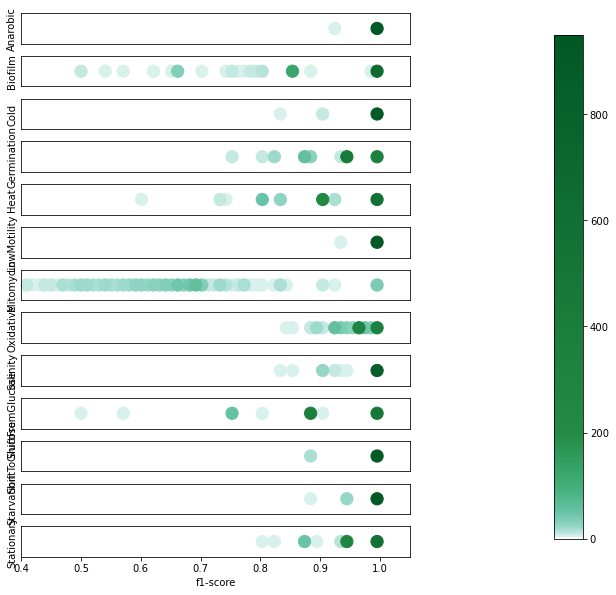

In [273]:
import matplotlib.cm as cm
import matplotlib.colors as col

f,a = plt.subplots(13,1,figsize=(8,10))
# f.tight_layout() 
a = a.ravel()
y_labs = y.columns

cvals  = [0,5,20,50,100,200,949]
colors = ["#ffffff","#ccece6","#99d8c9","#66c2a4","#41ae76","#238b45","#005824"]

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = col.LinearSegmentedColormap.from_list("", tuples)
for idx,ax in enumerate(a):
    full_f1s = y.iloc[:,idx]


    bins = np.linspace(0, 1, 100)
    #weightsa = np.ones_like(full_f1s)/float(len(full_f1s))
    hist, bin_edges=np.histogram(np.array(full_f1s), bins) 
    
    # Sort the points by density, so that the densest points are plotted last
#     x = np.random.normal(size=len(hist))
    y_values = np.zeros(len(hist))
    x_values = np.array([(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])
    re_idx = hist.argsort()
    
    im = ax.scatter(x_values[re_idx], y_values[re_idx], c=hist[re_idx],cmap=cmap, norm=norm,s=150)
 
    _ = ax.set_ylabel('')
    _ = ax.set_yticks([])
    if idx<12:
        _ = ax.set_xticks([])
        _ = ax.set_xlabel('')
    else:
        _ = ax.set_xlabel('f1-score')
    _ = ax.set_ylabel(y_labs[idx])
    _ = ax.set_xlim(0.4, 1.05)

    
    
f.subplots_adjust(right=0.8,wspace=0.05, hspace=0.4)
cbar_ax = f.add_axes([1.05, 0.15, 0.05, 0.7])
f.colorbar(im, cax=cbar_ax)

plt.savefig('../figures/scatterhist_traindata.pdf', bbox_inches='tight')




In [4]:
# alpha here is lambda in some elasticnet equation, and l1_ratio is alpha
l1_ratio_list = [1e-4,1e-3,1e-2,0.1,0.3,0.5,0.7,0.9]
alphas_list = np.linspace(0.1, 1, 10)
regr = ElasticNetCV(cv=10,alphas=alphas_list,l1_ratio=l1_ratio_list,n_jobs=4,random_state=0)
regr.fit(X, y)
print('coefficients:',regr.coef_)
print('intercept:',regr.intercept_)
print('optimal alpha:',regr.alpha_)
print('optimal L1 ration:',regr.l1_ratio_)

ElasticNetCV(alphas=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
             cv=10, l1_ratio=[0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9],
             n_jobs=4, random_state=0)

coefficients: [ 0.00308195 -0.00296231  0.00124422  0.00038554  0.00474563 -0.00059125
 -0.00088916  0.00196042  0.00039604]
intercept: 0.94565428627376
optimal alpha: 0.2
optimal L1 ration: 0.0001


<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

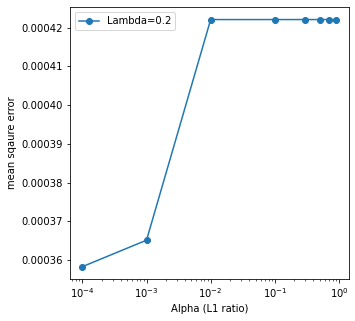

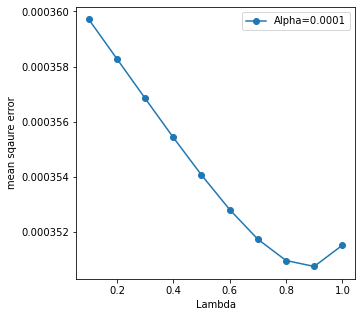

In [310]:
### Elastic Network parameter tunning

plt.figure(figsize = (5,5))
msePerLamda = np.mean(regr.mse_path_,axis=2)[:,alphas_list==regr.alpha_].flatten() 
_ = plt.plot(l1_ratio_list,msePerLamda,'-o',label='Lambda={}'.format(regr.alpha_))
_ = plt.legend()
_ = plt.xlabel('Alpha (L1 ratio)')
ax = plt.gca()
_ = ax.set_xscale('log')
_ = plt.ylabel('mean sqaure error')
_ = plt.savefig('../figures/AlphaTune.pdf')
plt.figure(figsize = (5,5))
msePerAlpha= np.mean(regr.mse_path_,axis=2)[l1_ratio_list==regr.l1_ratio_,:].flatten()
_ = plt.plot(alphas_list,msePerAlpha,'-o',label='Alpha={}'.format(regr.l1_ratio_))
_ = plt.legend()
_ = plt.xlabel('Lambda')
_ = plt.ylabel('mean sqaure error')
_ = plt.savefig('../figures/LambdaTune.pdf')

ElasticNet(alpha=0.2, l1_ratio=0.0001)

ElasticNet(alpha=0.2, l1_ratio=0.0001)

ElasticNet(alpha=0.2, l1_ratio=0.0001)

ElasticNet(alpha=0.2, l1_ratio=0.0001)

ElasticNet(alpha=0.2, l1_ratio=0.0001)

ElasticNet(alpha=0.2, l1_ratio=0.0001)

ElasticNet(alpha=0.2, l1_ratio=0.0001)

ElasticNet(alpha=0.2, l1_ratio=0.0001)

ElasticNet(alpha=0.2, l1_ratio=0.0001)

ElasticNet(alpha=0.2, l1_ratio=0.0001)

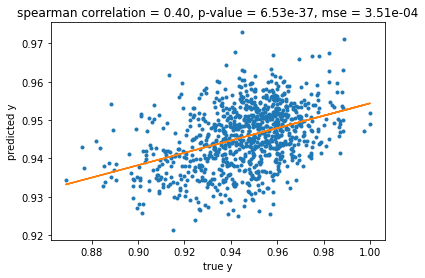

In [7]:
### recommendation system training

kf=KFold(n_splits=10, random_state=None, shuffle=False)
y_hat_folds = np.zeros(len(y))

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regr_fold = ElasticNet(alpha=regr.alpha_,l1_ratio=regr.l1_ratio_)
    regr_fold.fit(X_train, y_train)

    y_hat_folds[test_index] = regr_fold.predict(X_test)
#     regr_fold.score(X_test,y_test)
#     mean_squared_error(y_test,regr_fold.predict(X_test))
    
_ = plt.plot(y,y_hat_folds,'.')
# _ = plt.plot([y.min(), y.max()], [y_hat_folds.min(), y_hat_folds.max()], 'k', lw=1)
b, m = polyfit(y,y_hat_folds, 1)
_ = plt.plot(y, b + m * y, '-')

_ = plt.xlabel('true y')
_ = plt.ylabel('predicted y')
rho, pval = stats.spearmanr(y,y_hat_folds)
mse = mean_squared_error(y,y_hat_folds)

_ = plt.title('spearman correlation = {:.2f}, p-value = {:.2e}, mse = {:.2e}'.format(rho,pval,mse))
_ = plt.show()

ElasticNet(alpha=0.2, l1_ratio=0.0001)

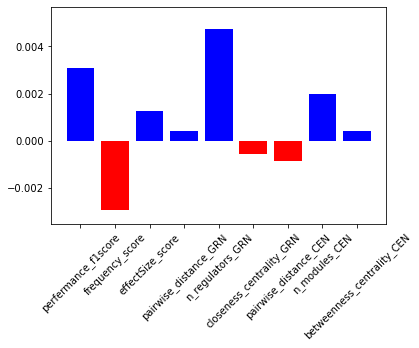

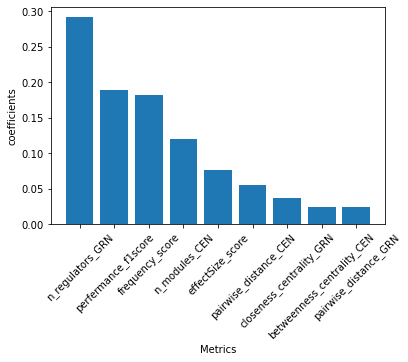

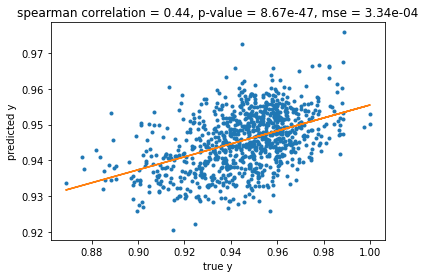

In [8]:
# 
regr_full = ElasticNet(alpha=regr.alpha_,l1_ratio=regr.l1_ratio_)
regr_full.fit(X, y)



_ = plt.bar(metric_names,regr_full.coef_,color=['blue' if weight>0 else 'red' for weight in regr_full.coef_])
_ = plt.ylim([np.min(regr_full.coef_)*1.2,np.max(regr_full.coef_)*1.2])
_ = plt.xticks(rotation=45)
_ =plt.show()
abs_weights= abs(regr_full.coef_)
abs_weights = abs_weights/sum(abs_weights)
idx_sort = np.argsort(abs_weights)[::-1]
_ = plt.bar(metric_names[idx_sort],abs_weights[idx_sort])
_ = plt.xlabel('Metrics')
_ = plt.xticks(rotation=45)
_ = plt.ylabel('coefficients')
_ =plt.show()


_ =plt.savefig('./figures/bar_absWeights.pdf')





y_hat = regr_full.predict(X) #np.sum(X* regr.coef_, axis=1)+regr.intercept_
_ = plt.plot(y,y_hat,'.')
# _ = plt.plot([y.min(), y.max()], [y_hat_folds.min(), y_hat_folds.max()], 'k', lw=1)
b, m = polyfit(y,y_hat, 1)
_ = plt.plot(y, b + m * y, '-')
_ = plt.xlabel('true y')
_ = plt.ylabel('predicted y')
rho, pval = stats.spearmanr(y,y_hat)
mse = mean_squared_error(y,y_hat)
_ = plt.title('spearman correlation = {:.2f}, p-value = {:.2e}, mse = {:.2e}'.format(rho,pval,mse))

_ =plt.savefig('./figures/scatter_model_full.pdf')



In [229]:
idx_sort = np.argsort(abs_weights)[::-1]


regr_full.coef_[idx_sort]

array([ 0.00474563,  0.00308195, -0.00296231,  0.00196042,  0.00124422,
       -0.00088916, -0.00059125,  0.00039604,  0.00038554])

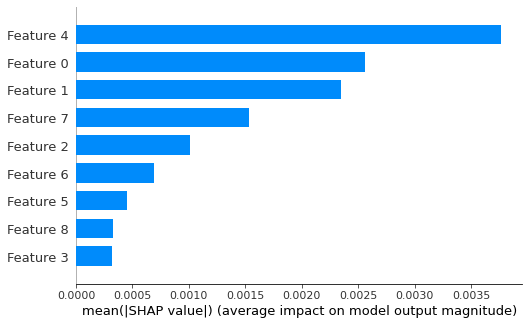

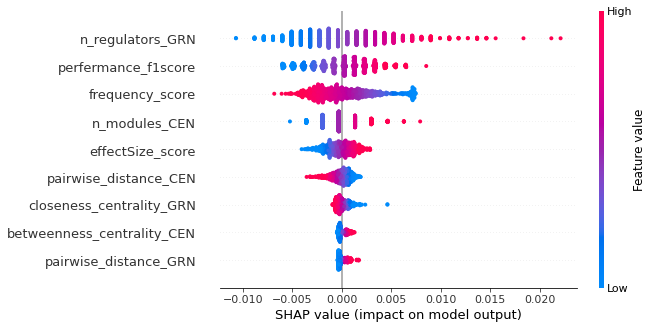

In [9]:
import shap
shap_linear = shap.explainers.Linear(regr_full, X)
shap_values = shap_linear.shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")
f = plt.figure()

shap.summary_plot(shap_values, X,feature_names=metric_names,plot_type='dot')
_ =f.savefig('./figures/shap_model.pdf')



<Figure size 720x432 with 0 Axes>

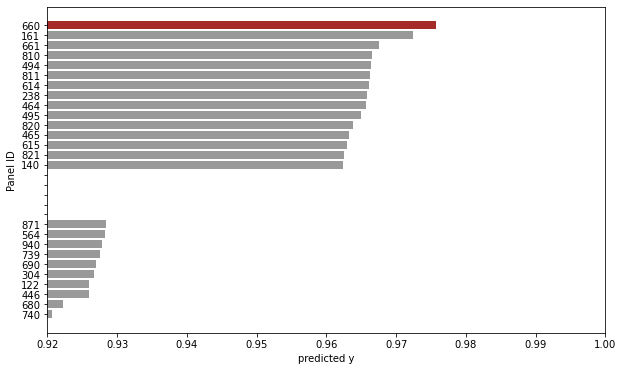

In [10]:
plt.figure(figsize = (10,6))

idx_sort =y_hat.argsort()
widths = np.concatenate([y_hat[idx_sort[:10]],np.empty(5) * np.nan,y_hat[idx_sort[-15:]]])
_ = plt.barh(range(len(widths)),widths,color=['brown' if i==29 else '#999999' for i in range(len(widths))])
_ = plt.xlim([0.92,1.0])
_ = plt.ylabel('Panel ID')
_ = plt.yticks(ticks=range(len(widths)),labels=np.concatenate([[str(x) for x in idx_sort[:10]],np.repeat('',5),[str(x) for x in idx_sort[-15:]]]))
_ = plt.xlabel('predicted y')

plt.savefig('./figures/bar_yhat_rank.pdf')


In [107]:
y_ext = pd.read_csv('../results/StressSensingIndex_external_biomarker.csv',index_col=0)
y_ext_random = pd.read_csv('../results/StressSensingIndex_external_random.csv',index_col=0)


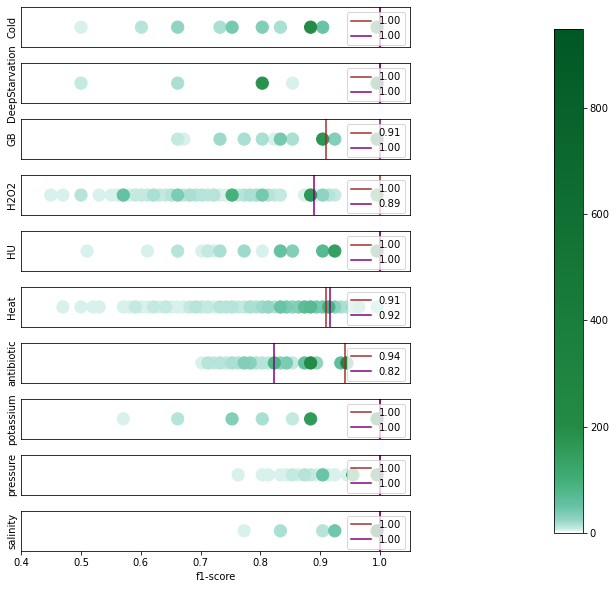

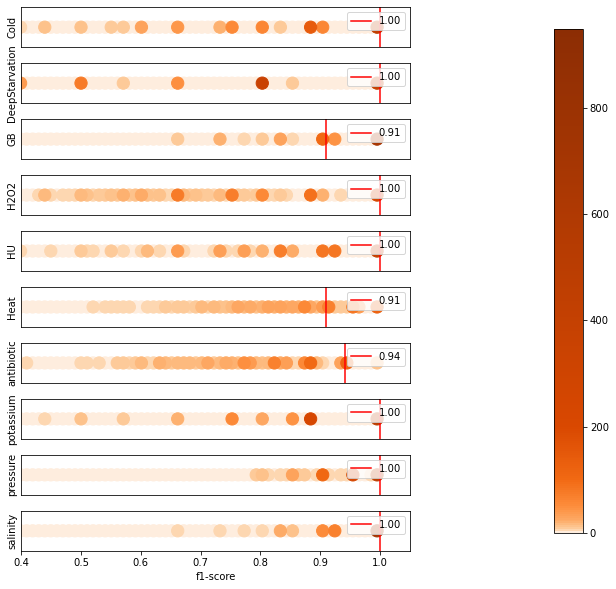

In [19]:
import matplotlib.cm as cm
import matplotlib.colors as col
y_true = pd.read_csv('../results/StressSensingIndex.csv',index_col=0).to_numpy()
y_true = np.mean(y_true,axis=1)

f,a = plt.subplots(10,1,figsize=(8,10))
# f.tight_layout() 
a = a.ravel()
y_labs = y_ext.columns

cvals  = [0,5,20,50,100,200,949]
colors = ["#ffffff","#ccece6","#99d8c9","#66c2a4","#41ae76","#238b45","#005824"]

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = col.LinearSegmentedColormap.from_list("", tuples)
for idx,ax in enumerate(a):
    full_f1s = y_ext.iloc[:,idx]
    recommend_f1 = y_ext.iloc[np.argmax(y_hat),idx]
    TopInternal_f1 = y_ext.iloc[np.argmax(y_true),idx]


    bins = np.linspace(0, 1, 100)
    #weightsa = np.ones_like(full_f1s)/float(len(full_f1s))
    hist, bin_edges=np.histogram(np.array(full_f1s), bins) 
    
    # Sort the points by density, so that the densest points are plotted last
#     x = np.random.normal(size=len(hist))
    y = np.zeros(len(hist))
    x = np.array([(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])
    re_idx = hist.argsort()
    
    im = ax.scatter(x[re_idx], y[re_idx], c=hist[re_idx],cmap=cmap, norm=norm,s=150)
 
    _ = ax.set_ylabel('')
    _ = ax.set_yticks([])
    if idx<9:
        _ = ax.set_xticks([])
        _ = ax.set_xlabel('')
    else:
        _ = ax.set_xlabel('f1-score')
    _ = ax.set_ylabel(y_labs[idx])
    _ = ax.set_xlim(0.4, 1.05)
    _ = ax.axvline(recommend_f1,color='brown', label='{:.2f}'.format(recommend_f1))
    _ = ax.axvline(TopInternal_f1,color='purple', label='{:.2f}'.format(TopInternal_f1))


    _ = ax.legend()
    
f.subplots_adjust(right=0.8,wspace=0.05, hspace=0.4)
cbar_ax = f.add_axes([1.05, 0.15, 0.05, 0.7])
f.colorbar(im, cax=cbar_ax)

plt.savefig('../figures/scatterhist.pdf', bbox_inches='tight')



f,a = plt.subplots(10,1,figsize=(8,10))
# f.tight_layout() 
a = a.ravel()
y_labs = y_ext_random.columns

cvals  = [0,5,20,50,100,200,949]
colors = ["#feedde","#fdd0a2","#fdae6b","#fd8d3c","#f16913","#d94801","#8c2d04"]

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = col.LinearSegmentedColormap.from_list("", tuples)
for idx,ax in enumerate(a):
    full_f1s = y_ext_random.iloc[:,idx]
    recommend_f1 = y_ext.iloc[np.argmax(y_hat),idx]
    bins = np.linspace(0, 1, 100)
    #weightsa = np.ones_like(full_f1s)/float(len(full_f1s))
    hist, bin_edges=np.histogram(np.array(full_f1s), bins) 
    
    # Sort the points by density, so that the densest points are plotted last
#     x = np.random.normal(size=len(hist))
    y = np.zeros(len(hist))
    x = np.array([(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])
    re_idx = hist.argsort()
    
    im = ax.scatter(x[re_idx], y[re_idx], c=hist[re_idx],cmap=cmap, norm=norm,s=150)
 
    _ = ax.set_ylabel('')
    _ = ax.set_yticks([])
    if idx<9:
        _ = ax.set_xticks([])
        _ = ax.set_xlabel('')
    else:
        _ = ax.set_xlabel('f1-score')
    _ = ax.set_ylabel(y_labs[idx])
    _ = ax.set_xlim(0.4, 1.05)
    _ = ax.axvline(recommend_f1,color='red', label='{:.2f}'.format(recommend_f1))
    _ = ax.legend()
    
f.subplots_adjust(right=0.8,wspace=0.05, hspace=0.4)
cbar_ax = f.add_axes([1.05, 0.15, 0.05, 0.7])
f.colorbar(im, cax=cbar_ax)

plt.savefig('../figures/scatterhist.pdf', bbox_inches='tight')


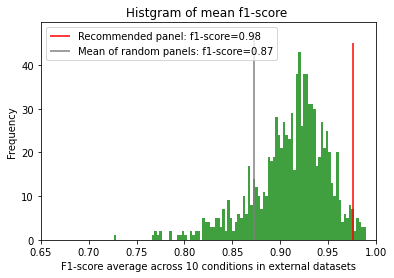

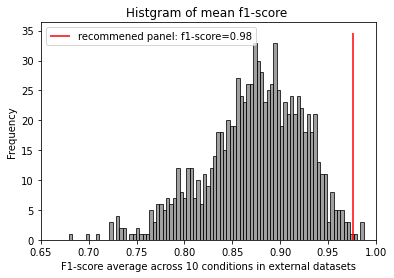

In [12]:
full_f1s = np.mean(y_ext.to_numpy(),axis=1)
recommend_f1 = full_f1s[np.argmax(y_hat)]
y_ext_randomMean = y_ext_random.mean().mean()

_ = plt.figure(0)
n, bins, patches = plt.hist(full_f1s, 100, facecolor='g', alpha=0.75)
_ = plt.xlabel('F1-score average across 10 conditions in external datasets')
_ = plt.ylabel('Frequency')
_ = plt.title('Histgram of mean f1-score ')
_ = plt.xlim(0.65, 1.0)
_ = plt.vlines(recommend_f1, ymin=0, ymax=plt.gca().get_ylim()[1],color='red', label='Recommended panel: f1-score={:.2f}'.format(recommend_f1))

_ = plt.vlines(y_ext_randomMean, ymin=0, ymax=plt.gca().get_ylim()[1],color='grey', label='Mean of random panels: f1-score={:.2f}'.format(y_ext_randomMean))

_ = plt.legend()
plt.savefig('../figures/hist_mean.pdf')


full_f1s = np.mean(y_ext_random.to_numpy(),axis=1)
_ = plt.figure(1)


n, bins, patches = plt.hist(full_f1s, 100, facecolor='g', alpha=0.75,fc = "grey", ec="black")
_ = plt.xlabel('F1-score average across 10 conditions in external datasets')
_ = plt.ylabel('Frequency')
_ = plt.title('Histgram of mean f1-score ')
_ = plt.xlim(0.65, 1.0)
_ = plt.vlines(recommend_f1, ymin=0, ymax=plt.gca().get_ylim()[1],color='red', label='recommened panel: f1-score={:.2f}'.format(recommend_f1))
_ = plt.legend()
plt.savefig('../figures/hist_mean_random.pdf')





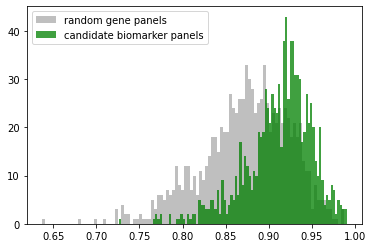

In [3]:
y_ext = pd.read_csv('./y_c10.csv',index_col=0)
y_ext_random = pd.read_csv('./y_c10_random.csv',index_col=0)


full_f1s_random = np.mean(y_ext_random.to_numpy(),axis=1)
n2, bins2, patche2s = plt.hist(full_f1s, 100, facecolor='g', alpha=0.5,fc = "grey", label='random gene panels')

full_f1s = np.mean(y_ext.to_numpy(),axis=1)
n1, bins1, patches1 = plt.hist(full_f1s, 100, facecolor='g', alpha=0.75, label='candidate biomarker panels')

_ = plt.legend()
#plt.savefig('../figures/HistRandomBiomarker.pdf')

